In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
save_location = "/media/bhux/alpha/xsd_mvp/30000e_normalized/"

# uniform, lg, gaussian

NUMERICAL = 12
CATEGORICAL = 0

INFILLING_TYPE = ''
NOISE_TYPE = ''

In [3]:
from utils import remove_outliers, norm, sample_local_gaussian, convert_categorical, unison_shuffled_copies, invert_categorical_norm


In [4]:
def xyhist(x, y, title):
    plt.hist(x, bins=50, alpha=0.5, label='Synthetic', density=True)
    plt.hist(y, bins=50, alpha=0.5, label='Real', density=True)
    plt.title(title)
    plt.yscale('log')
    plt.xlabel("Normalized Range")
    plt.ylabel("Probability Density")
    plt.legend(loc='upper right')
    plt.show()

In [5]:
PATH = "./data/xtended_data_all.csv"
gt = pd.read_csv(PATH).drop(labels=['Drug'], axis=1)
f = pd.read_csv(PATH)
smiles = f['Drug'].values
vlists = {
    col: f[col].values for col in f.drop(labels=['Drug'], axis=1).columns[:12] 
}



inmask = remove_outliers([v for _,v in vlists.items()])
print(sum(inmask))
smiles = smiles[inmask]
vlists = {
    k: v[inmask] for k,v in vlists.items()
}

# vlists = {
#     k: norm(v) for k,v in vlists.items()
# }

nullmask = np.stack([
    np.isnan(v)==False for _,v in vlists.items()
    ], axis=-1)

dmss = []
for k,v in vlists.items():
    vlists[k], dms = sample_local_gaussian(v, numbins=25)
    dmss.append(dms)

for col in f.drop(labels=['Drug'], axis=1).columns[:12]:
    vlists[col+"_cat"] = convert_categorical(vlists[col], numbins=25)

print(vlists)

filename = "/media/bhux/alpha/xsd_mvp/3000e_optimal_cat_normalized/20_dict.csv"
vals = pd.read_csv(filename).values

smiles_vs = []
preds = {i:[] for i in range(len(vlists.items()))}
for v in vals:
    v[1] = [float(s) for s in v[1].split("[")[1].split("]")[0].split(" ") if s != '']
    smiles_vs.append(v[0])
    for i, val in enumerate(v[1]):
        preds[i].append(val)

print(np.array(preds.keys()))

for i, col in enumerate(f.drop(labels=['Drug'], axis=1).columns[:12]):
    preds[i] = invert_categorical_norm(vlists[col], preds[i], preds[i+12], 25)

# preds = {
#     k: norm(preds[k]) for k in range(12)
# }

print(preds)

33128
{'Caco2_Wang': array([-5.43275108, -5.3989701 , -4.89562635, ..., -4.87667873,
       -4.59557692, -4.9161044 ]), 'Lipophilicity_AstraZeneca': array([1.68658916, 2.00993552, 1.2027271 , ..., 3.34983427, 2.71240919,
       2.70748691]), 'Solubility_AqSolDB': array([-1.77114025, -2.38962895, -0.19632857, ...,  0.09697106,
        0.66120213, -2.83086188]), 'HydrationFreeEnergy_FreeSolv': array([ 1.95718633, -9.68431933, -4.38682365, ..., -3.03858636,
       -0.75345763, -2.37767409]), 'PPBR_AZ': array([96.72243496, 97.64709666, 97.78292456, ..., 87.7170663 ,
       99.5815823 , 96.56127339]), 'VDss_Lombardo': array([0.67032772, 0.14998448, 0.1852517 , ..., 0.13718407, 0.2       ,
       0.63319823]), 'Half_Life_Obach': array([1.7102382 , 1.88949204, 1.80397097, ..., 0.88633992, 6.69560294,
       6.44568111]), 'Clearance_Hepatocyte_AZ': array([121.81121191,   6.32434669,   8.2435415 , ...,  15.03931371,
         2.90699752,   6.19780158]), 'Clearance_Microsome_AZ': array([23.602144

Index(['Caco2_Wang', 'Lipophilicity_AstraZeneca', 'Solubility_AqSolDB',
       'HydrationFreeEnergy_FreeSolv', 'PPBR_AZ', 'VDss_Lombardo',
       'Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'Clearance_Microsome_AZ',
       'LD50_Zhu', 'herg_central_hERG_at_1uM', 'herg_central_hERG_at_10uM',
       'PAMPA_NCATS', 'HIA_Hou', 'Pgp_Broccatelli', 'Bioavailability_Ma',
       'BBB_Martins'],
      dtype='object')
0 0
0
preds -4.792829051937415 1.6501258478618201
act -5.243819732521347 0.7651655604350922
here
0 1
1
preds 2.0372251105484587 1.291695164068305
act 2.2287365598597453 1.1692340233987863
here
0 2
2
preds -2.5677702310784842 2.3435012150880272
act -2.8073685679386227 2.3014973610279075
here
0 3
3
preds -3.191405591289986 3.254472764606896
act -3.4920657150177603 3.2346684583538994
here
1 0
4
preds 84.6956959118522 27.233423522340477
act 92.68773986341758 8.337534984581032
here
1 1
5
preds 1.2028313866890719 1.4579165370414435
act 1.3129726052371584 1.4676657405830775
here
1 2
6
pr

IndexError: list index out of range

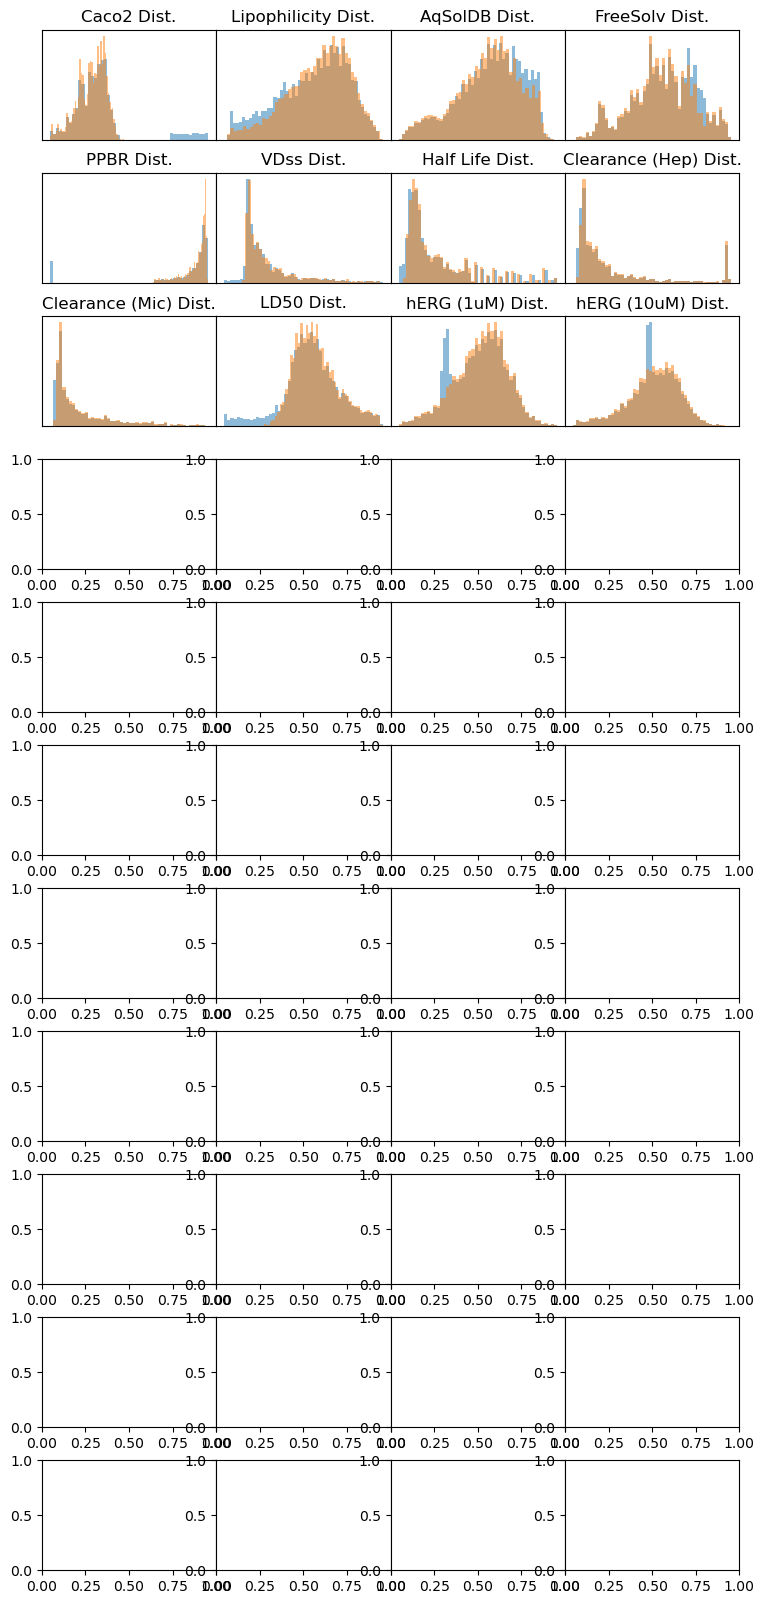

In [6]:
fig = plt.figure(figsize=(9,20))
gs = fig.add_gridspec(11,4, wspace=0, hspace=0.3)
ax = gs.subplots(sharey=False, sharex=False)

print(gt.columns)
names = [
    "Caco2",
    "Lipophilicity",
    "AqSolDB",
    "FreeSolv",
    "PPBR",
    "VDss",
    "Half Life",
    "Clearance (Hep)",
    "Clearance (Mic)",
    "LD50",
    "hERG (1uM)",
    "hERG (10uM)",
    # Categorical
    # "Caco2_cat",
    # "Lipophilicity_cat",
    # "AqSolDB_cat",
    # "FreeSolv_cat",
    # "PPBR_cat",
    # "VDss_cat",
    # "Half Life_cat",
    # "Clearance (Hep)_cat",
    # "Clearance (Mic)_cat",
    # "LD50_cat",
    # "hERG (1uM)_cat",
    # "hERG (10uM)_cat",
    # 'PAMPA_NCATS',
    # 'HIA_Hou',
    # 'Pgp_Broccatelli',
    # 'Bioavailability_Ma',
    # 'BBB_Martins',
    # 'CYP2C19_Veith',
    # 'CYP2D6_Veith',
    # 'CYP3A4_Veith',
    # 'CYP1A2_Veith',
    # 'CYP2C9_Veith',
    # 'CYP2C9_Substrate',
    # 'CYP2D6_Substrate',
    # 'CYP3A4_Substrate',
    # 'AMES',
    # 'DILI',
    # 'Skin Reaction',
    # 'Carcinogens_Lagunin',
    # 'ClinTox',
    # 'Tox21NR-AR', 'Tox21NR-AR-LBD', 'Tox21NR-AhR', 'Tox21NR-Aromatase',
    #    'Tox21NR-ER', 'Tox21NR-ER-LBD', 'Tox21NR-PPAR-gamma', 'Tox21SR-ARE',
    #    'Tox21SR-ATAD5', 'Tox21SR-HSE', 'Tox21SR-MMP', 'Tox21SR-p53'
]

for c, (col, y) in enumerate(vlists.items()):
    #print(c//6, c%6)
    i = c // 4
    j = c % 4

    print(i,j)

    x = preds[c]

    print(c)
    print("preds", np.average(x), np.std(x))
    print("act", np.average(y), np.std(y))
    
    bins=50
    if c > 12:
        bins=14
    if c< 12:
        print("here")

    ax[i][j].set_title(f"{names[c]} Dist.", fontsize=12)
    ax[i][j].hist(x, bins=bins, alpha=0.5, label='Synthetic', density=True)
    ax[i][j].hist(y, bins=bins, alpha=0.5, label='Real', density=True)
    # ax[i][j].set_ylim(0,2.8)
    # ax[i][j].set_xlim(-1,1)
    # if c > 12:
    #     ax[i][j].set_ylim(0,0.5)
    #     ax[i][j].set_xlim(0,15)
    ax[i][j].get_xaxis().set_ticks([])
    ax[i][j].get_yaxis().set_ticks([])
    #plt.yscale('log')

    # xyhist(preds[i], vlists[col], f"{col} Real vs Synthetic Data (Epoch: {e})")

ax[0][0].legend(loc='upper left', fontsize=11, frameon=False)
fig.suptitle("Real vs Synthetic Data (Density)", fontsize=14)